In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%matplotlib inline
import numpy 
import random
import time 
import sys
import os
import tifffile
import io
import pickle
import matplotlib
import yaml

from matplotlib import pyplot
from PIL import Image
from tqdm.auto import trange
from skimage import filters

from pysted import base, utils, raster, bleach_funcs
from banditopt.objectives import Resolution, Bleach
from banditopt.utils import get_foreground

from stedopt.tools import DatamapGenerator
from stedopt.create import create_microscope, create_dymin_microscope, create_rescue_microscope
from stedopt.experiment import Experiment
from stedopt.defaults import P_EX, P_STED, PDT



# FIRST EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 3.5801577460614683e-09,  # found through optim
#         750: 4.450819912845956e-09 / 100,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6,
#     "k0" : 0,
#     "k1" : 1.3e-15,
#     "b" : 1.4,
#     "triplet_dynamic_frac" : 0,    
# }

fluo = { # ATTO647N
    "lambda_": 690e-9, # Figure 1, Oracz2017
    "qy": 0.65,  # Product Information: ATTO 647N (ATTO-TEC GmbH)
    "sigma_abs": {
        635: 2.14e-20, #Table S3, Oracz2017
        750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz2017
    },
    "sigma_ste": {
#         750: 4.8e-22, #Table S3, Oracz2017
        750: 3.0e-22, #Table S3, Oracz2017        
    },
    "tau": 3.5e-9, #Table S3, Oracz2017
    "tau_vib": 1.0e-12, #t_vib, Table S3, Oracz2017 
    "tau_tri": 1.2e-6, # pasted from egfp
    "k0": 0, #Table S3, Oracz2017
#     "k1": 1.3e-15, #Table S3,  (changed seemingly wrong unit: 5.2 × 10−10 / (100**2)**1.4)
#     "b":1.4, #Table S3, Oracz2017    
#     "k1": 1.3e-15, #tests_photobleaching.py 2022-08-28
    "k1": 1.3e-15, #tests_photobleaching.py 2022-08-28    
    "b": 1.62, #Table S3, Oracz2017    
    "triplet_dynamics_frac": 0, #Ignore the triplet dynamics by default
}

objective = {"transmission" : {488: 0.84, 535: 0.85, 550: 0.86, 585: 0.85, 575: 0.85, 635: 0.85, 690: 0.85, 750: 0.85}}
laser_ex = {"lambda_" : 635e-9}
laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.005, "anti_stokes" : False}
num_mol = 40

# # SECOND EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 2.98094869e-09,  # found through optim
#         750: 9.15758276e-08 / 1000,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6  # COPIED FROM BEFORE
# }
# laser_ex = {"lambda_" : 635e-9}
# laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01}
# num_mol = 450

# # OTHER EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 3.053e-05,  # found through optim
#         750: 4.26e-09,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6  # COPIED FROM BEFORE
# }
# laser_ex = {"lambda_" : 635e-9}
# laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01}
# num_mol = 23


Could not load microscope interface. Some functions may not be available.
No module named 'specpy'
Calling these functions might raise an error.

Falling back to the debug files...


In [ ]:
def kb_map_to_im_bleach(kb_map, dwelltime, linestep):
    """ 
    Bleaching estimate for an infinite number of fluorophores
    kb_map being the map of k_bleach convolving each pixel
    """
    return 1 - numpy.exp((-kb_map * dwelltime * linestep).sum())

def expected_bleach(p_ex, p_sted, k1, b):
    i_ex = __i_ex * p_ex #the time averaged excitation intensity
    i_sted = __i_sted * p_sted #the instant sted intensity (instant p_sted = p_sted/(self.sted.tau * self.sted.rate))
    phi_ex =  fluo.get_photons(i_ex, lambda_=lambda_ex)
    phi_sted = fluo.get_photons(i_sted, lambda_=lambda_sted)
    dwelltime = params_dict0["dwelltime"]
    #print([lambda_ex, lambda_sted, phi_ex, phi_sted, tau_sted, tau_rep, dwelltime])
    # I enter the instant sted power
    fluo.k1 = k1
    fluo.b = b
    kb_map = fluo.get_k_bleach(lambda_ex, lambda_sted, phi_ex, phi_sted*tau_sted/tau_rep, tau_sted, tau_rep, dwelltime)
    linestep = params_dict0["line_repetitions"]
    bleach = kb_map_to_im_bleach(kb_map, dwelltime, linestep)
    return bleach

In [2]:
def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        dirname = os.path.dirname(savepath)
        basename = os.path.basename(savepath)
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb))    

In [3]:
P_STED = 150e-3
P_EX = 2.0e-6
PDT = 10.0e-6

numpy.random.seed(42)
random.seed(42)

NUM_ACQ = 1
NUM_REPS = 1
all_histories = []
all_confocal_histories = []
i = 1
datamap_generator = DatamapGenerator(
    mode="real", shape=(224, 224), path=["../../data/datamap/psd95"], random_state=42 + i,
    molecules=num_mol, sources=25
)
print(datamap_generator.datamaps[0])
for i in trange(min(10, len(datamap_generator.datamaps)), leave=False):
# for i in trange(len(datamap_generator.datamaps), leave=False):    
    molecules_disposition, positions = datamap_generator(idx=i + 20)

    confocal_experiment = Experiment()
    conf_microscope, datamap, conf_params = create_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : 2e-6, "p_sted" : P_STED, "pdt" : 10e-6}
    )
    confocal_experiment.add("Conf", conf_microscope, datamap, conf_params)

    confocal_histories = confocal_experiment.acquire_all(NUM_ACQ, bleach=False, processes=1, verbose=False)
    all_confocal_histories.append(confocal_histories)

../../data/datamap/psd95/1.npy


  0%|          | 0/10 [00:00<?, ?it/s]

6.0
10.0
6.0


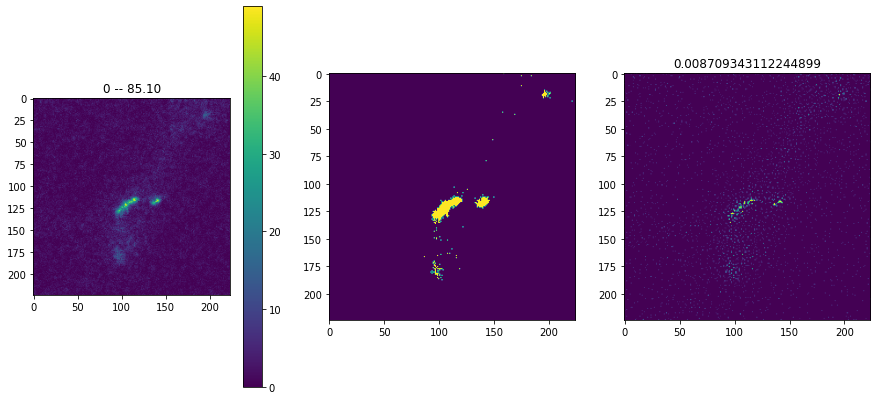

7.0
10.0
7.0


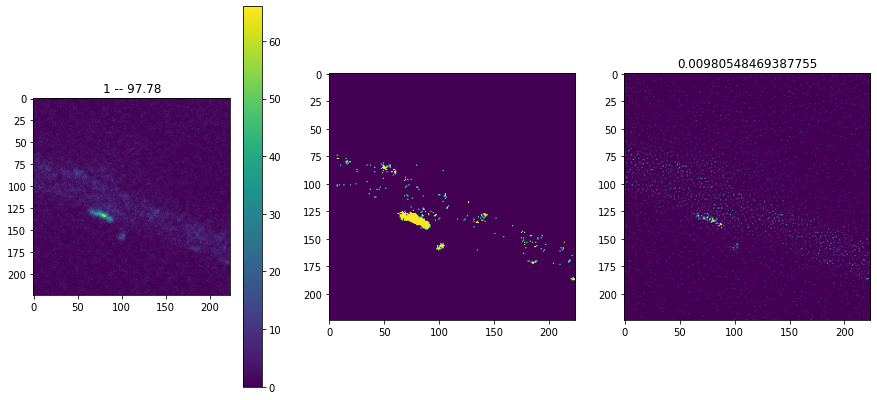

5.0
13.0
5.0


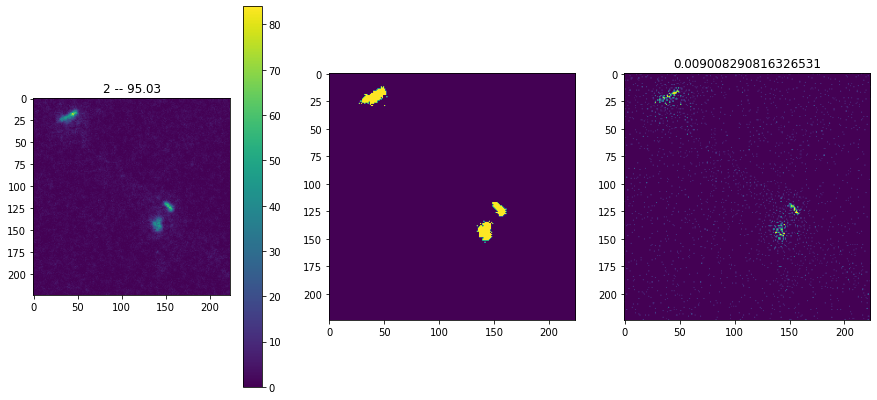

10.0
22.0
10.0


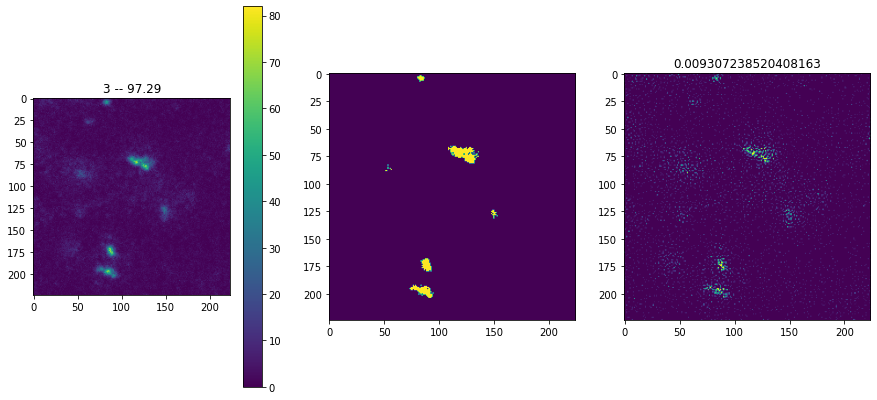

9.0
17.0
9.0


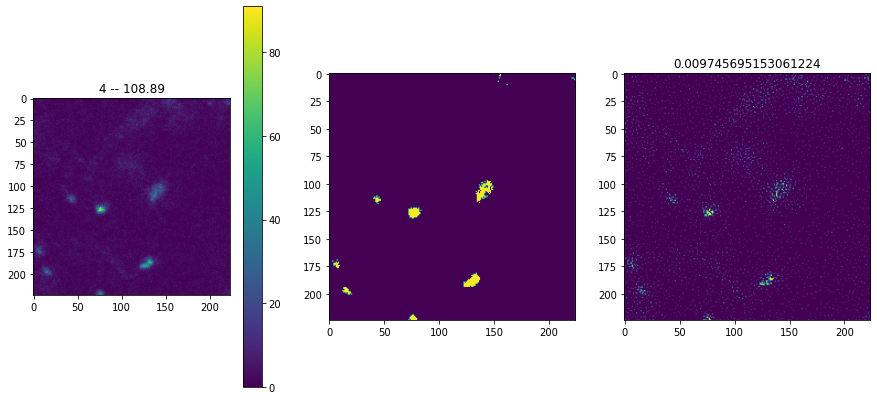

7.0
12.0
7.0


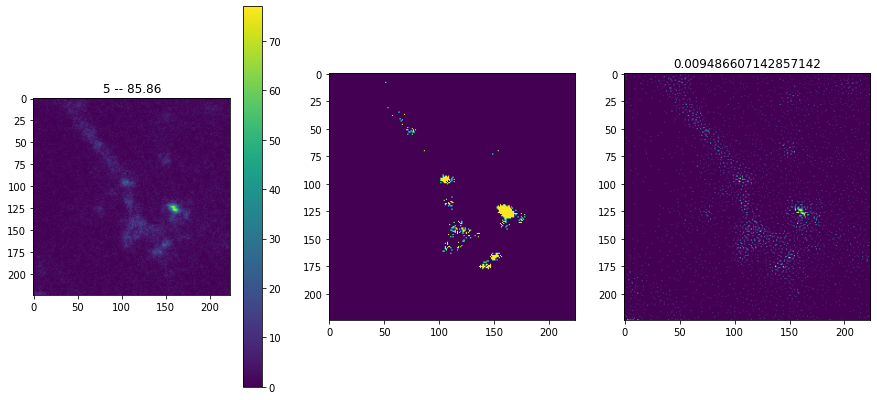

9.0
18.0
9.0


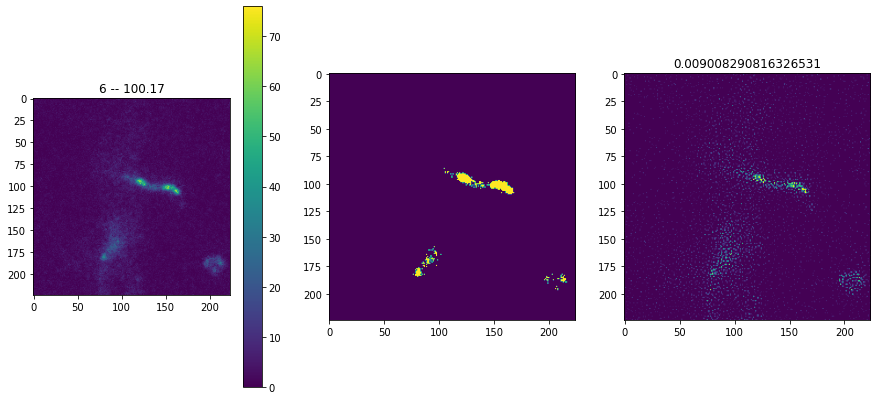

5.0
10.0
5.0


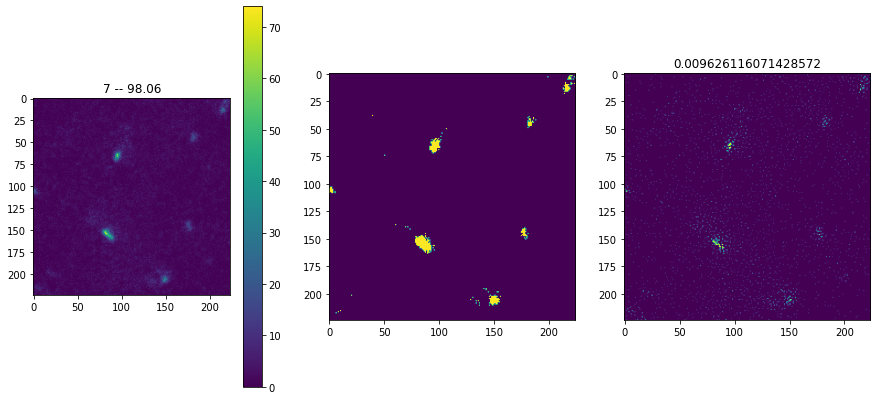

5.0
8.0
5.0


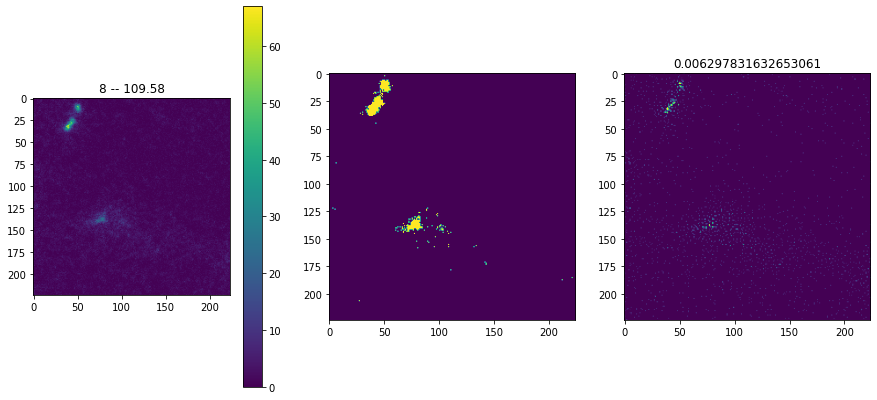

5.0
9.0
5.0


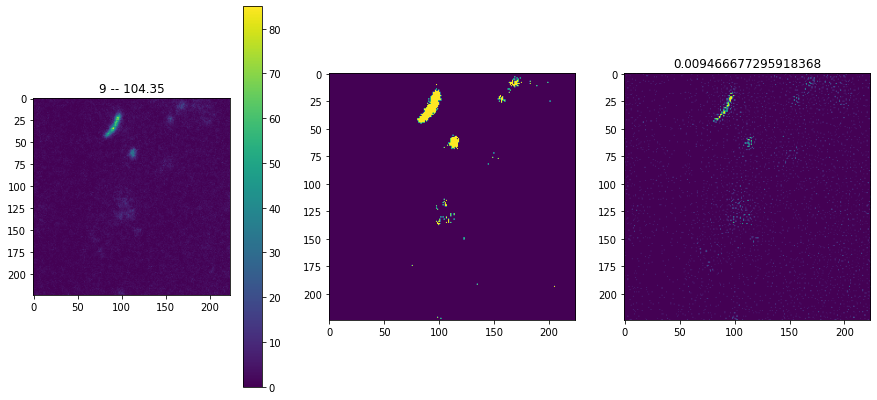

In [54]:
def get_foreground(img):
    threshold = filters.threshold_otsu(img)
    threshold = numpy.quantile(img, 0.99)
    print(threshold)
    return img > threshold

resolution_objective = Resolution(20e-9)
for idx, history in enumerate(all_confocal_histories):
    conf = history["Conf"]["acquisition"][-1]
    datamap = history["Conf"]["datamap"][-1]

    foreground = get_foreground(datamap)
    
    resolution = resolution_objective.evaluate([conf], conf, conf, foreground, foreground)
    fig, axes = pyplot.subplots(1, 3, figsize=(15, 7))
    im = axes[0].imshow(conf)
    axes[0].set_title(f"{idx} -- {resolution:0.2f}")
    axes[1].imshow(get_foreground(conf))
    axes[2].imshow(datamap)
    axes[2].set_title(get_foreground(datamap).sum() / numpy.prod(conf.shape))
    pyplot.colorbar(im, ax=axes[0])
    pyplot.show()